In [103]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [104]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

,,tweet,"HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000",SUB CATEGORY,COMMENTS,labels,SUB CATEGORY.1,COMMENTS.1,human category (Tarun),SUB CATEGORY.2,COMMENTS.2,NEW CATEGORY,keyword,human - category,human - Sub category,Comment,HUMAN CATGEORY_NEW(ARYA),location,COMMENTS (FROM PARIJAAT),Category,Sub-category
0,2,"@LondOgrad Hello Eugene, we do apologise for t...",CUSTOMER_SERVICE_ISSUES,NaN,bad customer service,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,customer_service issues,delay,Delay,delay in calls,Huge Queues,customer_service_issues,"London, UK",NaN,{'category': 'Delay',subcategory': 'Delay in bounce back loan'
1,8,@ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...,BAD REPUTATION,NaN,NaN,General,NaN,NaN,NaN,NaN,NaN,Bad_reputation,unhappy,{'category': 'Reputation',subcategory': 'Bad reputation',worst experience from customer – mess,BAD_REPUTATION,"Plymouth, England",NaN,{'category': 'Reputation',subcategory': 'Good reputation'
2,9,"@sharaola Good morning, sorry for your experie...",CUSTOMER_SERVICE_ISSUES,NaN,bad customer service,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,customer_service issues,customerservice,{'category': 'customer_service issues',subcategory': 'customerservice',General response from bank,General,"Cairo, Egypt",General message from hsbc,{'category': 'Reputation',subcategory': 'Good reputation'
3,11,@Bounce_BackLoan Still not a peep from HSBC,DELAY,Delay_in_bounce_back_loan,delay in bounce back loan,DELAY,Delay_in_bounce_back_loan,delay in bounce back loan,NaN,NaN,NaN,Delay_Bounceback_Loan,"delay , no response",{'category': 'Bounce back loan',subcategory': 'Bounce back loan delays',No reply,DELAY_BOUNCEBACK_LOAN,"Enschede, Nederland",DELAY,{'category': 'Bounce back loan',subcategory': 'Bounce back loan delays'
4,15,@djm2481 @mgcmitchell @HSBC_UK Thanks for the ...,Customer Service Response,NaN,customer service reply,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,General,any queries,{'category': 'Reputation',subcategory': 'General Response from Bank (tha...,General response from bank,NaN,United Kingdom,NaN,{'category': 'Reputation',subcategory': 'Good reputation'


In [105]:
df.labels.value_counts().sum()

4462

In [106]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [107]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [108]:
df.tweet.str.contains("bye").sum()

3

In [109]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [110]:
def clean_hashtag(text):
    text = text.lower()
    list_data2=[]
    
    sentence=text.split(' ')
    for word in sentence:
        if not (word.startswith('@') | word.startswith('http')| word.startswith('#')):
            list_data2.append(word)
    return " ".join([t for t in list_data2])
df.tweet=df.tweet.apply(lambda x: clean_hashtag(x))

In [111]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [112]:
replace_word = {"covid":"covid", "corona":"covid","pandemi":"covid", 
                "bouncebackloan":"bounce back loan", "noresponse":"no response", 
                "bounceback":"bounce back", "backloan":"back loan","on hold":"on_hold",
                "bbl":"bounce back loan", "any news":"any_news","give up":"give_up", 
                "gave up":"give_up", "well done":"well_done"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [113]:
junk_words = "nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [114]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [115]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if word == 
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [116]:
"lai".isalpha()

True

In [117]:
df.tweet.str.contains("worst").sum()

68

In [118]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        if token.text=="worst" or token.text=="worse":
            lemma = token.text
        else:
            lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(x))  

In [119]:
df.tweet.str.contains("bye").sum()

5

In [120]:
word_root("worst")

'worst'

In [121]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [122]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [123]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [124]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [125]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [126]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [127]:
bigrams

['can not',
 'stay safe',
 'absolute joke',
 'that s',
 'what s',
 'live chat',
 'name postcode',
 'full name',
 'you re',
 'information hence',
 'hence request',
 'refer link',
 'post code',
 'direct message',
 'order assist',
 'credit card',
 'click link',
 'concerned team',
 'link below',
 'name post',
 'have nt',
 'let know',
 'send sm',
 'mobile number',
 'good morning',
 'week ago',
 'two week',
 'team touch',
 'exist customer',
 'hello mr',
 'customer care',
 'bounce back',
 'hear anything',
 'hear nothing',
 'set feeder',
 'need information',
 'assist need',
 'feeder account',
 'back loan',
 'please click',
 'sorry hear',
 'thank write',
 'phone service',
 'worst customer',
 'still wait',
 'customer service',
 'personal account',
 'request call',
 'still nothing',
 'I think',
 'apply bounce',
 'call phone',
 'hello sorry',
 'apply feeder',
 'please send',
 'business customer',
 'business account',
 'loan application',
 'I want',
 'wait day',
 'account number',
 'please help',
 

In [128]:
trigrams

['sm hsbcsm register',
 'hsbcsm register mobile',
 'regret every second',
 'stay safe claude',
 'connect minute person',
 'absolute joke worst',
 'regard concern refer',
 'mobile number fetch',
 'send sm hsbcsm',
 'minute person set',
 'full name postcode',
 'work quickly possible',
 'team touch youalpa',
 'information hence request',
 'register mobile number',
 'name post code',
 'number fetch detail',
 'digit complaint number',
 'full name post',
 'concern refer link',
 'name postcode dm',
 'need information hence',
 'service regard concern',
 'write order assist',
 'experience business life',
 'kindly write concern',
 'person set feeder',
 'fetch detail send',
 'click link below',
 'dm direct message',
 'provide full name',
 'team check priority',
 'order assist need',
 'business life year',
 'kindly send sm',
 'direct message use',
 'second call connect',
 'call connect minute',
 'write concern detail',
 'post code dm',
 'assist refer link',
 'hence request call',
 'joke worst cust

In [129]:
replace_ngrams = {"bounce back loan":"bounce_back_loan", "name post code":"name_post_code","full name":"full_name",
                  "credit card":"credit_card","click link below":"click_link_below",
                  "worst customer experience":"worst_customer_experience",
                  "thank respond back":"thank_respond_back","phone service team":"phone_service_team",
                  "thank write back":"thank_write_back","feeder account":"feeder_account", "still wait":"still_wait",
                  "business account":"business_account","business customer":"business_customer","good morning":"good_morning",
                  "week ago":"week_ago","post code":"post_code","click link":"click_link","let know":"let_know",
                  "call back":"call_back","personal account":"personal_account","refer link":"refer_link","link below":"link_below",
                  "name post":"name_post","hear nothing":"hear_nothing","sorry hear":"sorry_hear", "hello thank":"hello_thank",
                  "loan application":"loan_application","loan apply":"loan_apply"}
for key, value in replace_ngrams.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [130]:
df.tweet.str.contains("worst").sum()

68

In [131]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.tweet.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [132]:
df.tweet[df.tweet.str.contains("tatacrucible")]

Series([], Name: tweet, dtype: object)

In [133]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [134]:
df.tweet[df.tweet.str.contains("fromthequizmaster")]

Series([], Name: tweet, dtype: object)

In [135]:
df_clean = df.tweet
df_clean.shape

(2967,)

In [136]:
df_clean = df_clean.dropna()
df_clean.shape

(2967,)

In [137]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [138]:
from sentence_transformers import SentenceTransformer

In [139]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [140]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [141]:
# embeddings1[embeddings1.argmax()]

In [142]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [143]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [144]:
import umap

In [145]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [146]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [147]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [148]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [149]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.006591310692013809

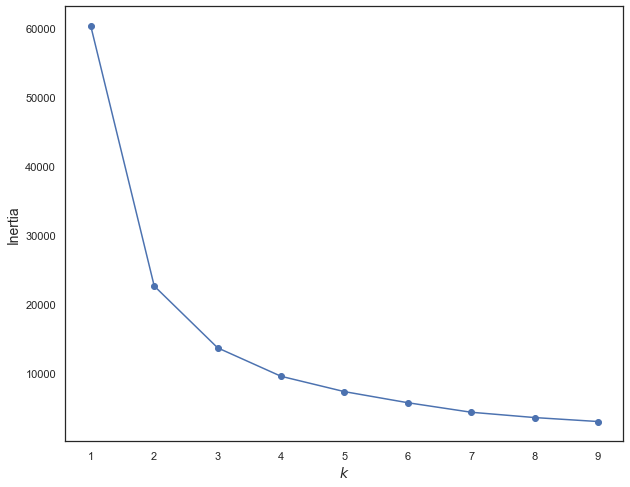

In [150]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [151]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [152]:
clustering_result = cluster_results()

In [153]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 347, 1: 934, 2: 962, 3: 724}


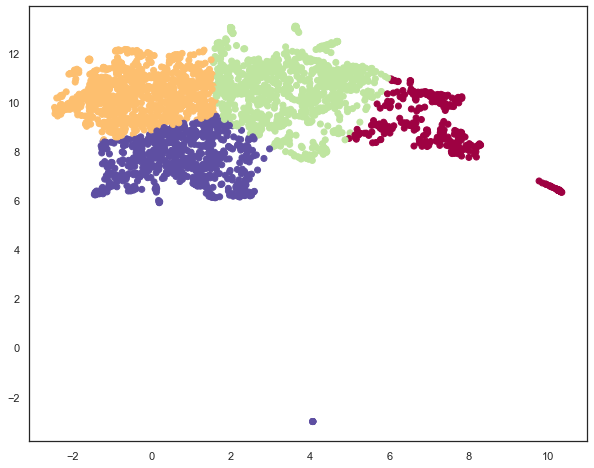

----------UMAP_bert1_hdbscan--------------------
{-1: 7, 0: 55, 1: 2905}


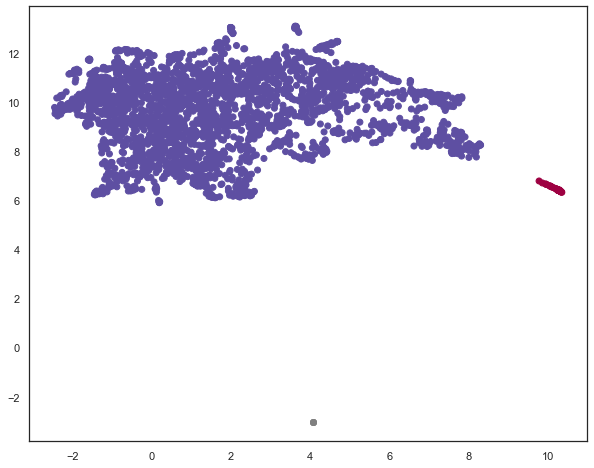

----------UMAP_bert1_norm--------------------
{0: 911, 1: 708, 2: 904, 3: 444}


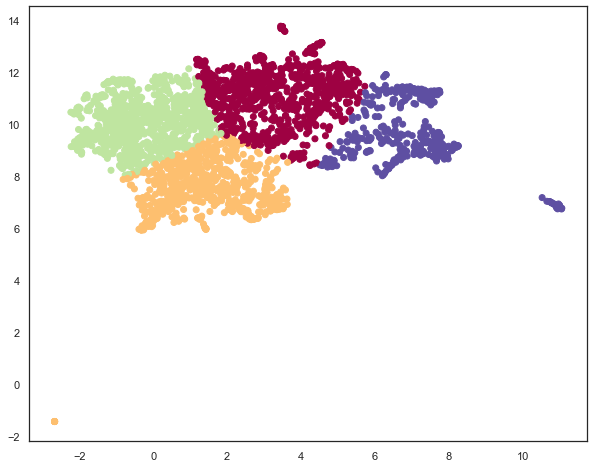

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 7, 0: 55, 1: 2905}


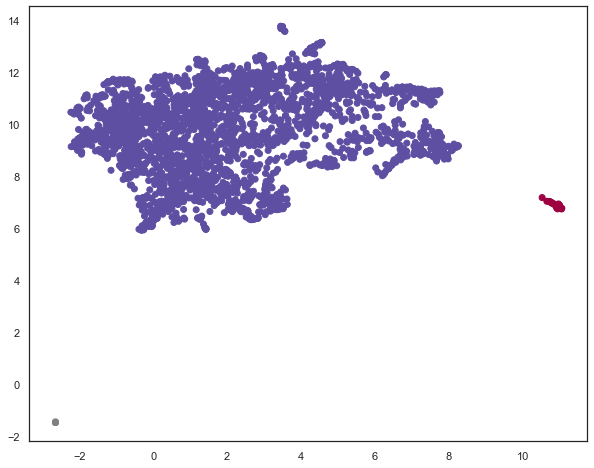

----------UMAP_bert2--------------------
{0: 867, 1: 43, 2: 1230, 3: 827}


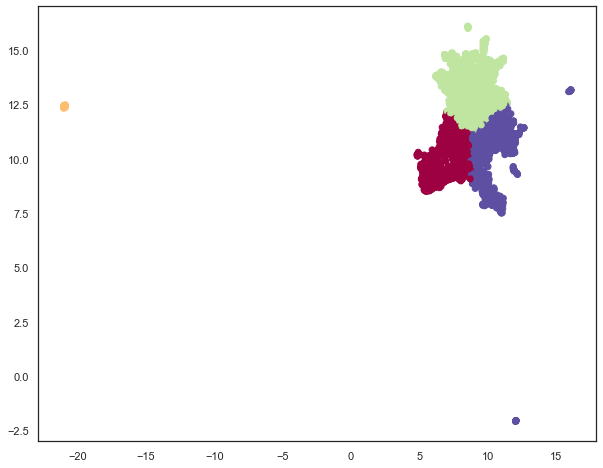

----------UMAP_bert2_hdbscan--------------------
{0: 43, 1: 2924}


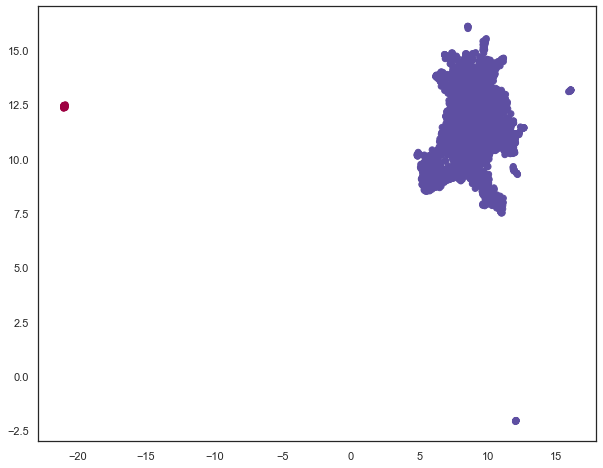

----------UMAP_bert2_norm--------------------
{0: 1193, 1: 601, 2: 865, 3: 308}


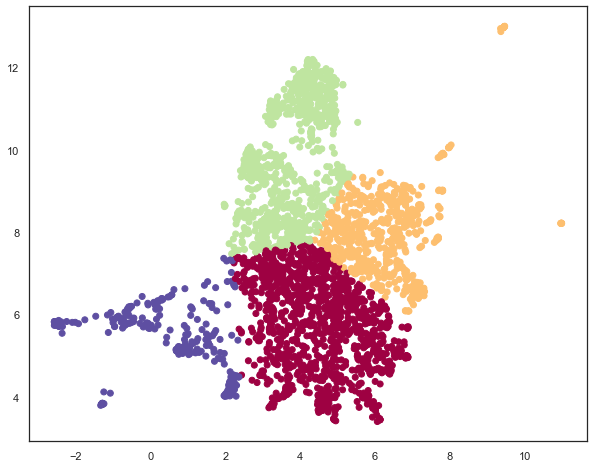

----------UMAP_bert2_norm_hdbscan--------------------
{-1: 272, 0: 56, 1: 60, 2: 46, 3: 46, 4: 352, 5: 2135}


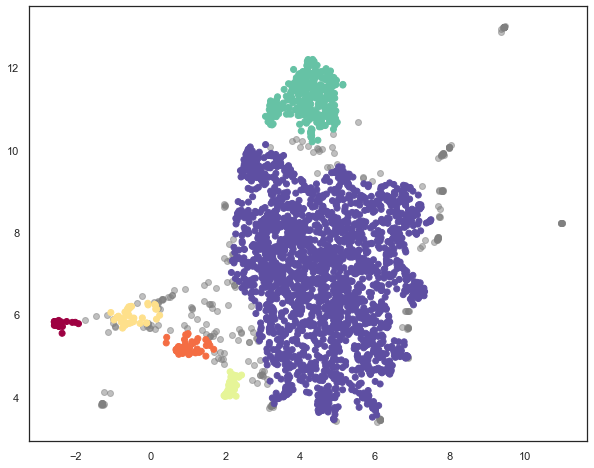

----------PCA_bert1--------------------
{0: 397, 1: 1011, 2: 802, 3: 757}


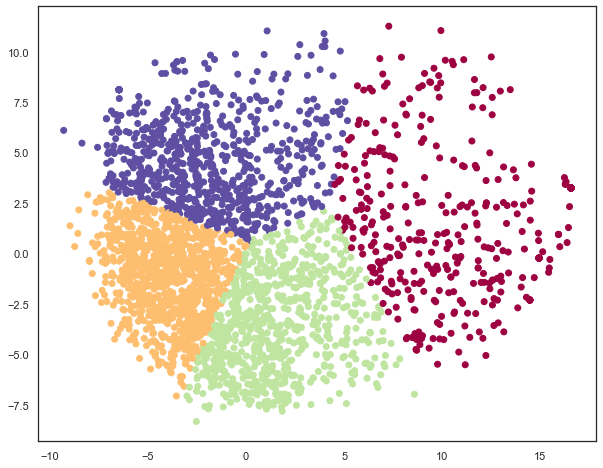

----------PCA_bert1_hdbscan--------------------
{-1: 188, 0: 2729, 1: 50}


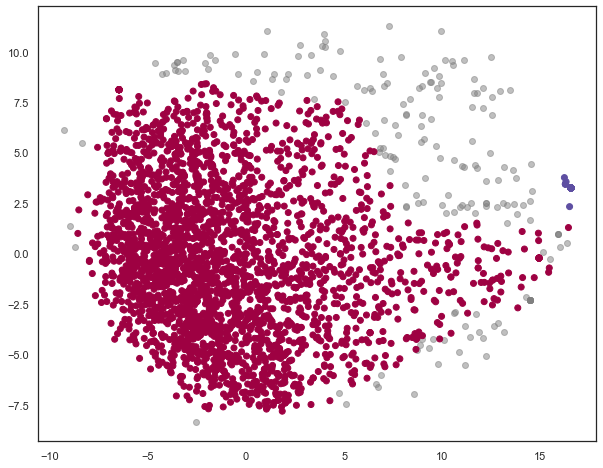

----------PCA_bert1_norm--------------------
{0: 427, 1: 1000, 2: 802, 3: 738}


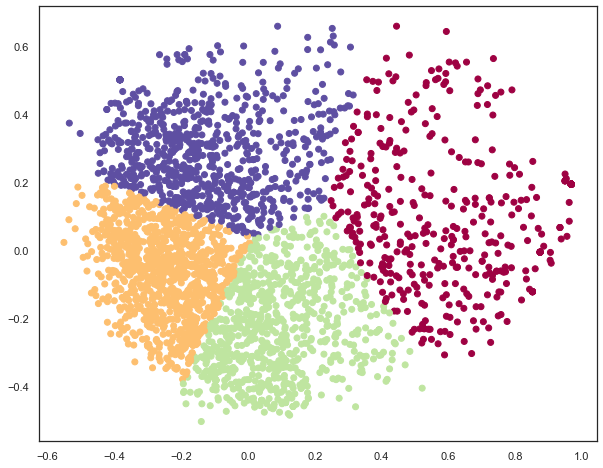

----------PCA_bert1_norm_hdbscan--------------------
{-1: 221, 0: 2696, 1: 50}


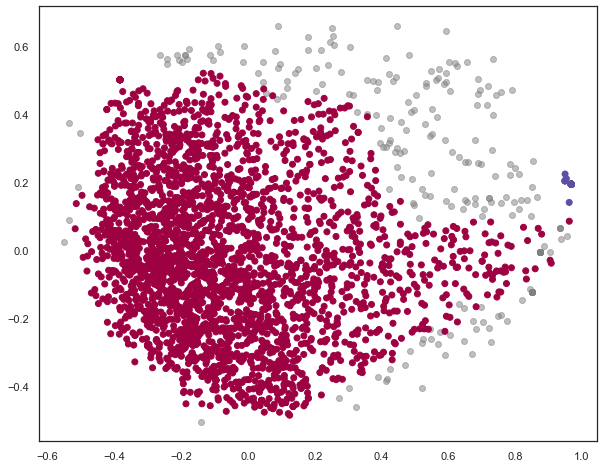

----------PCA_bert2--------------------
{0: 845, 1: 95, 2: 447, 3: 1580}


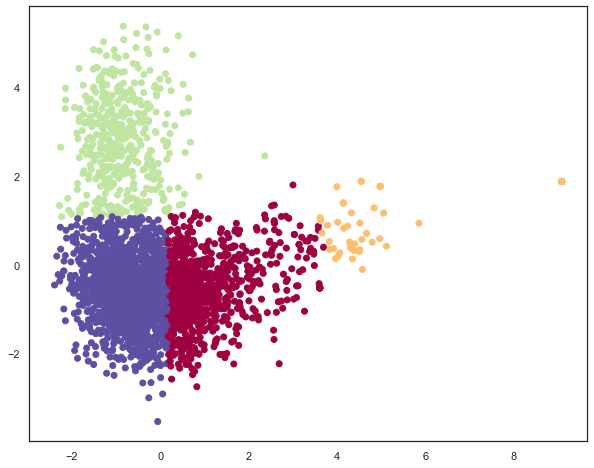

----------PCA_bert2_hdbscan--------------------
{0: 43, 1: 2924}


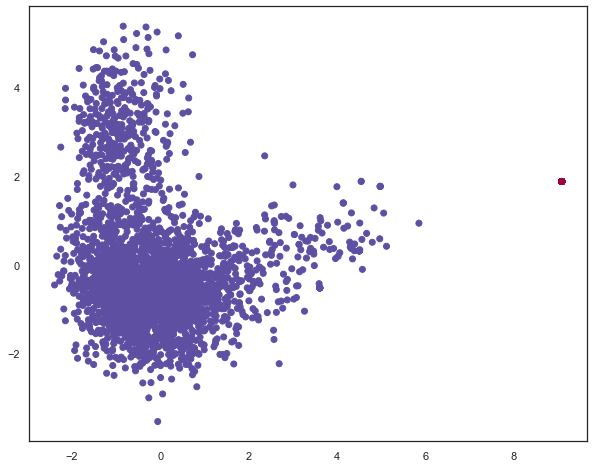

----------PCA_bert2_norm--------------------
{0: 411, 1: 167, 2: 1000, 3: 1389}


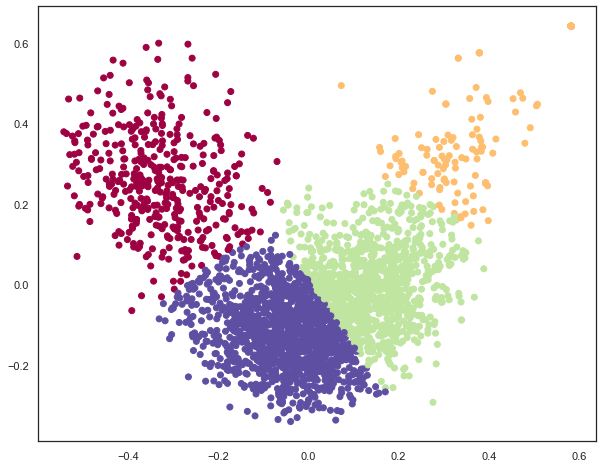

----------PCA_bert2_norm_hdbscan--------------------
{-1: 7, 0: 43, 1: 2917}


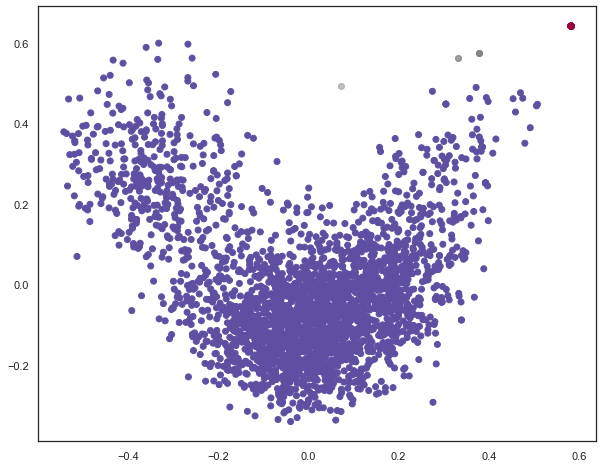

----------tSNE_bert1--------------------
{0: 724, 1: 842, 2: 834, 3: 567}


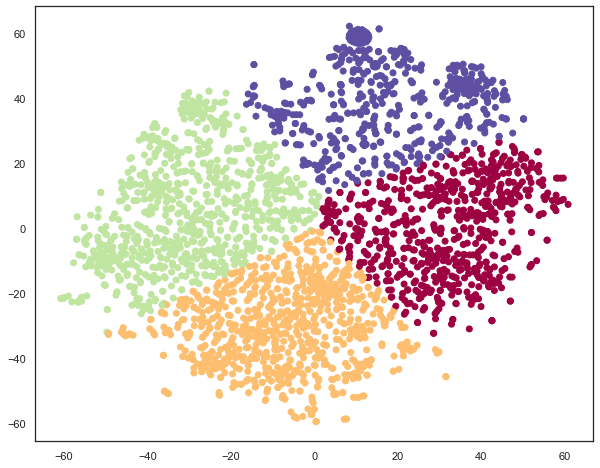

----------tSNE_bert1_hdbscan--------------------
{-1: 829, 0: 97, 1: 33, 2: 114, 3: 27, 4: 45, 5: 1822}


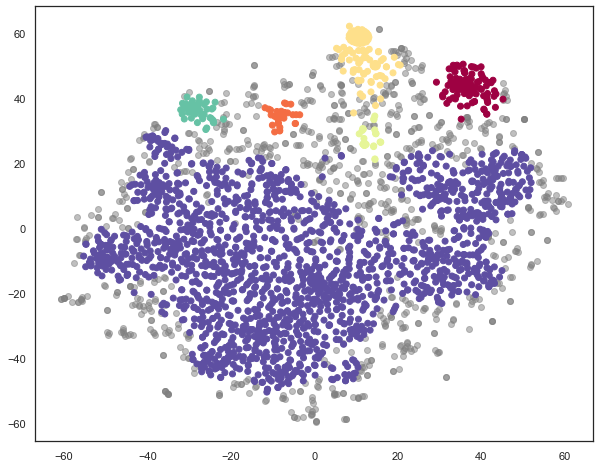

----------tSNE_bert1_norm--------------------
{0: 854, 1: 593, 2: 713, 3: 807}


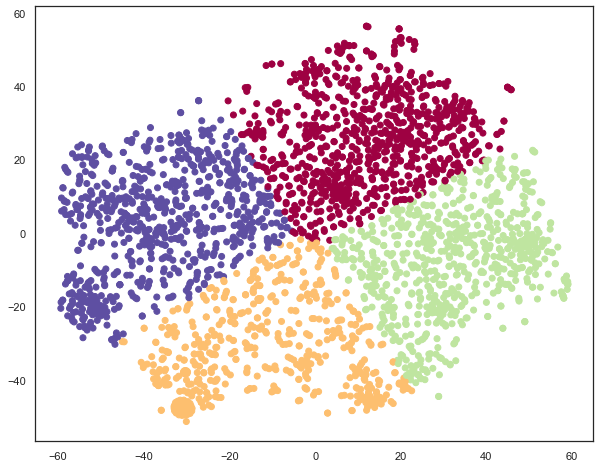

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 1026, 0: 34, 1: 95, 2: 97, 3: 17, 4: 141, 5: 25, 6: 1532}


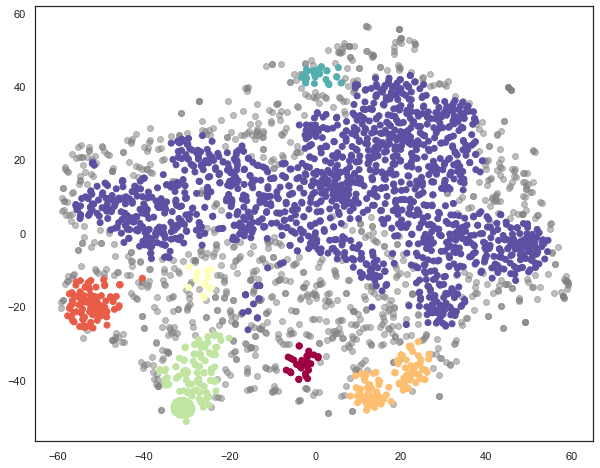

----------tSNE_bert2--------------------
{0: 902, 1: 755, 2: 772, 3: 538}


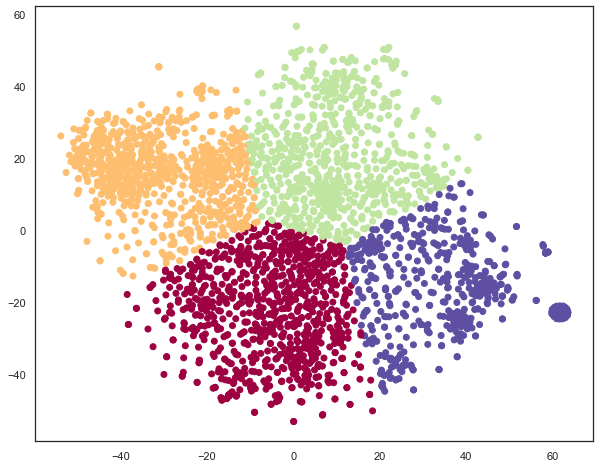

----------tSNE_bert2_hdbscan--------------------
{-1: 290, 0: 44, 1: 2633}


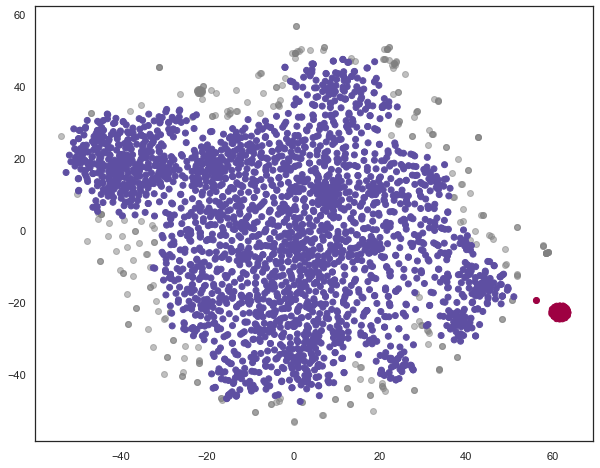

----------tSNE_bert2_norm--------------------
{0: 836, 1: 675, 2: 723, 3: 733}


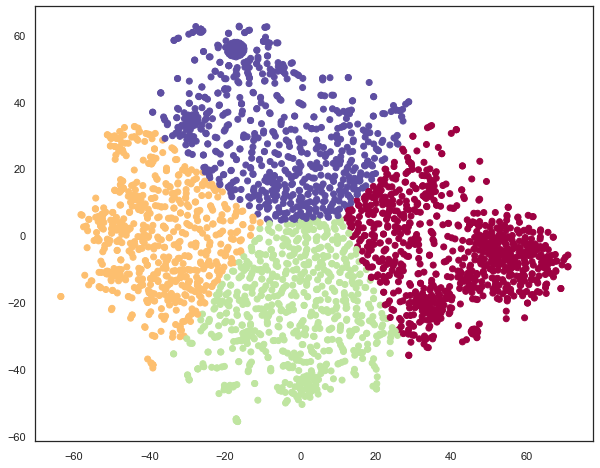

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 643, 0: 113, 1: 30, 2: 2118, 3: 63}


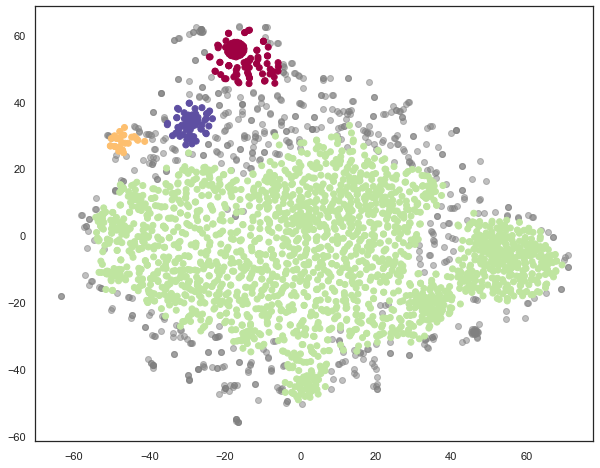

In [154]:
plot()

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [156]:
def cluster_words(clustering_result=clustering_result, top_n = 20, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [157]:
cluster_words(show_cross = True)

====================================UMAP_bert1=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,9,41,26,153
CHURN,5,8,4,20
COVID19,4,11,11,24
CUSTOMER_SERVICE_ISSUES,13,83,44,87
Customer Query,12,56,79,21
Customer Service Response,31,110,469,43
DELAY,22,429,78,187
ESG,1,1,1,3
GOOD REPUTATION,23,18,36,24


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,join,today,good,help,apply,day,please,customer,account,great,hello,same,support,an,zar,hear,make,nt,see
1,bounce_back_loan,feeder_account,apply,week,still_wait,day,week_ago,account,email,still,application,wait,call,good_morning,say,business_account,thank,time,hour,back
2,thank,hello,hello_thank,full_name,please,refer_link,send,help,team,email,call,account,click_link,feeder_account,number,let_know,kindly,need,sorry_hear,link_below
3,bounce_back_loan,feeder_account,customer,hear_nothing,nothing,worst_customer_experience,apply,call,account,still,worst,business,day,never,credit_card,say,email,service,year,money


====================================UMAP_bert1_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,0,1,228
CHURN,0,0,37
COVID19,7,0,43
CUSTOMER_SERVICE_ISSUES,0,0,227
Customer Query,0,0,168
Customer Service Response,0,0,653
DELAY,0,2,714
ESG,0,0,6
GOOD REPUTATION,0,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,infection,case,covid,new,nigeria,record,total,exceed,near,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse
0,an,money,ðÿœˆ,hadirrr,bust,link,need,pende,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute
1,bounce_back_loan,thank,feeder_account,hello,apply,account,please,call,day,help,email,customer,application,still_wait,send,wait,time,week,say,still


====================================UMAP_bert1_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,25,155,39,10
CHURN,4,20,8,5
COVID19,13,22,11,4
CUSTOMER_SERVICE_ISSUES,46,85,76,20
Customer Query,81,19,53,15
Customer Service Response,465,45,105,38
DELAY,59,172,431,54
ESG,2,3,0,1
GOOD REPUTATION,35,24,16,26


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,hello,hello_thank,full_name,please,refer_link,send,help,team,call,account,click_link,email,number,kindly,let_know,credit_card,need,sorry_hear,feeder_account
1,bounce_back_loan,feeder_account,customer,worst_customer_experience,nothing,hear_nothing,apply,call,account,worst,business,day,credit_card,service,time,say,money,still,try,never
2,bounce_back_loan,apply,feeder_account,week,day,week_ago,account,still_wait,application,wait,email,business_account,still,good_morning,call,thank,say,hear_nothing,time,back
3,thank,still_wait,day,good,help,please,see,doubledigit,asia,today,apply,join,make,customer,still,wealth,account,hello,hear,pay


====================================UMAP_bert1_norm_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,0,1,228
CHURN,0,0,37
COVID19,7,0,43
CUSTOMER_SERVICE_ISSUES,0,0,227
Customer Query,0,0,168
Customer Service Response,0,0,653
DELAY,0,2,714
ESG,0,0,6
GOOD REPUTATION,0,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,infection,case,covid,new,nigeria,record,total,exceed,near,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse
0,an,money,ðÿœˆ,hadirrr,bust,link,need,pende,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute
1,bounce_back_loan,thank,feeder_account,hello,apply,account,please,call,day,help,email,customer,application,still_wait,send,wait,time,week,say,still


====================================UMAP_bert2=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,59,1,80,89
CHURN,13,0,7,17
COVID19,0,0,6,44
CUSTOMER_SERVICE_ISSUES,36,0,140,51
Customer Query,32,0,89,47
Customer Service Response,35,0,583,35
DELAY,537,0,109,70
ESG,0,0,0,6
GOOD REPUTATION,10,0,41,50


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,feeder_account,apply,still_wait,application,day,week,wait,account,hear_nothing,business_account,still,email,business,sign,week_ago,say,customer,tell,personal_account
1,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse,abysmal,ac,academic,acb
2,thank,hello,full_name,hello_thank,please,call,send,credit_card,help,team,email,refer_link,let_know,number,click_link,link_below,phone,sorry_hear,time,need
3,account,thank,worst_customer_experience,customer,feeder_account,money,bounce_back_loan,covid,new,business,make,pay,payment,gold,market,help,support,year,say,hello


====================================UMAP_bert2_hdbscan=============================================


cluster,0,1
labels,,
BAD REPUTATION,1,228
CHURN,0,37
COVID19,0,50
CUSTOMER_SERVICE_ISSUES,0,227
Customer Query,0,168
Customer Service Response,0,653
DELAY,0,716
ESG,0,6
GOOD REPUTATION,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse,abysmal,ac,academic,acb
1,bounce_back_loan,thank,feeder_account,hello,apply,account,please,call,day,help,email,customer,application,still_wait,send,wait,time,week,say,still


====================================UMAP_bert2_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,88,64,55,22
CHURN,13,5,15,4
COVID19,7,39,4,0
CUSTOMER_SERVICE_ISSUES,149,47,28,3
Customer Query,64,61,39,4
Customer Service Response,515,47,41,50
DELAY,159,40,502,15
ESG,1,4,0,1
GOOD REPUTATION,32,40,10,19


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,full_name,thank,hello,call,hello_thank,please,send,team,email,customer,help,let_know,click_link,refer_link,link_below,sorry_hear,detail,call_back,name_post_code,number
1,credit_card,account,worst_customer_experience,thank,feeder_account,money,bounce_back_loan,customer,pay,covid,card,hello,help,payment,please,gold,month,new,call,business
2,bounce_back_loan,feeder_account,still_wait,apply,application,account,business_account,hear_nothing,day,wait,week,email,personal_account,week_ago,business_customer,customer,still,business,sign,take
3,thank,good_morning,query,happy,jp,assist,help,today,day,good,great,join,back,hope,tweet,zs,morning,hello,an,nzt


====================================UMAP_bert2_norm_hdbscan=============================================


cluster,-1,0,1,2,3,4,5
labels,,,,,,,
BAD REPUTATION,27,1,0,1,1,13,186
CHURN,3,0,1,0,0,8,25
COVID19,12,0,0,0,0,0,38
CUSTOMER_SERVICE_ISSUES,9,0,0,0,1,13,204
Customer Query,3,0,1,0,0,15,149
Customer Service Response,51,0,3,2,42,20,535
DELAY,21,1,2,6,0,233,453
ESG,0,0,1,0,0,0,5
GOOD REPUTATION,24,0,13,0,0,4,60


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,worst_customer_experience,bounce_back_loan,feeder_account,phone_service_team,click_link,call,refer_link,hello_thank,thank,gold,business,minute,set,joke,second,regret,absolute,life,person,send
0,an,today,block,bring,route,accord,mine,chance,need,try,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad
1,thank,support,ok,help,appreciate,give,share,bless,generous,look,grateful,pleased,tagging,wow,back,happy,say,answer,good,info
2,same,apply,yes,exactly,ditto,luck,good,both,business,nice,too,aggressive,defo,doesthank,donde,doom,hadirrr,ik,laugh,noand
3,good_morning,query,assist,happy,jp,day,morning,zs,everyone,tweet,help,thank,today,great,hope,tomorrow,nzt,ai,bl,back
4,bounce_back_loan,feeder_account,apply,application,day,still_wait,email,week_ago,account,business,business_customer,still,week,receive,business_account,hear_nothing,customer,sign,wait,fund
5,thank,hello,account,feeder_account,call,please,full_name,customer,email,send,still_wait,apply,credit_card,team,day,hello_thank,wait,help,still,application


====================================PCA_bert1=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,30,46,24,129
CHURN,4,11,4,18
COVID19,1,15,10,24
CUSTOMER_SERVICE_ISSUES,17,87,33,90
Customer Query,14,70,61,23
Customer Service Response,19,202,386,46
DELAY,53,358,51,254
ESG,1,1,1,3
GOOD REPUTATION,16,23,40,22


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,still_wait,still,join,apply,good,today,nothing,well,day,ok,pay,say,time,an,answer,be,customer,hear,hello
1,bounce_back_loan,feeder_account,apply,email,account,thank,hello,day,business_account,application,call,please,week_ago,wait,help,customer,week,call_back,say,send
2,thank,hello,hello_thank,full_name,please,help,refer_link,send,kindly,call,team,link_below,number,need,account,information,check,dm,sorry_hear,detail
3,bounce_back_loan,feeder_account,hear_nothing,apply,still_wait,customer,worst_customer_experience,week,day,week_ago,account,call,still,say,credit_card,wait,money,business,time,nothing


====================================PCA_bert1_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,35,193,1
CHURN,7,30,0
COVID19,0,50,0
CUSTOMER_SERVICE_ISSUES,11,216,0
Customer Query,3,165,0
Customer Service Response,9,644,0
DELAY,32,684,0
ESG,1,5,0
GOOD REPUTATION,11,90,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,thank,worst,customer,nothing,year,still,time,be,day,money,service,absolutely,apply,well,ever,help,leave,still_wait,week_ago,awful
0,bounce_back_loan,feeder_account,thank,hello,apply,account,please,call,day,email,help,hello_thank,full_name,customer,application,send,still_wait,wait,take,phone
1,an,honestly,oh,yeah,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse


====================================PCA_bert1_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,34,47,20,128
CHURN,4,11,4,18
COVID19,2,15,10,23
CUSTOMER_SERVICE_ISSUES,20,87,32,88
Customer Query,16,68,64,20
Customer Service Response,19,190,399,45
DELAY,58,364,49,245
ESG,1,1,1,3
GOOD REPUTATION,18,23,38,22


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,still_wait,still,join,apply,time,good,same,today,customer,nothing,well,answer,day,say,be,ok,pay,an,hear
1,bounce_back_loan,feeder_account,apply,email,account,thank,day,hello,business_account,application,call,please,week_ago,wait,help,customer,week,say,call_back,business
2,thank,hello,hello_thank,full_name,please,help,refer_link,send,call,kindly,team,link_below,number,account,need,click_link_below,information,sorry_hear,check,dm
3,bounce_back_loan,feeder_account,hear_nothing,apply,still_wait,worst_customer_experience,customer,week,day,week_ago,account,call,still,credit_card,say,wait,money,business,time,nothing


====================================PCA_bert1_norm_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,39,189,1
CHURN,7,30,0
COVID19,1,49,0
CUSTOMER_SERVICE_ISSUES,15,212,0
Customer Query,4,164,0
Customer Service Response,12,641,0
DELAY,34,682,0
ESG,1,5,0
GOOD REPUTATION,12,89,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,thank,worst,customer,join,nothing,service,day,apply,still,year,be,help,time,money,absolutely,awful,hello,hour,please,well
0,bounce_back_loan,feeder_account,thank,hello,apply,account,please,call,day,email,help,hello_thank,full_name,customer,application,still_wait,wait,send,take,business_account
1,an,honestly,oh,yeah,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse


====================================PCA_bert2=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,65,2,18,144
CHURN,10,0,9,18
COVID19,33,0,0,17
CUSTOMER_SERVICE_ISSUES,32,0,16,179
Customer Query,36,0,17,115
Customer Service Response,178,0,19,456
DELAY,63,4,289,360
ESG,6,0,0,0
GOOD REPUTATION,35,0,23,43


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,full_name,hello,please,help,good_morning,hello_thank,name_post_code,covid,dm,look,nt,link_below,let_know,time,click_link_below,team,see,be,sorry_hear
1,join,an,same,money,today,defo,donde,hsbcwell,mayis,noand,ouch,sortedthank,alone,bust,horrible,bring,joy,pende,accord,answer
2,bounce_back_loan,feeder_account,apply,day,application,business_account,business_customer,business,still_wait,worst_customer_experience,hear_nothing,week_ago,wait,week,email,account,still,call,call_back,customer
3,thank,hello,account,call,please,customer,send,email,credit_card,apply,help,day,wait,say,team,hello_thank,refer_link,time,application,number


====================================PCA_bert2_hdbscan=============================================


cluster,0,1
labels,,
BAD REPUTATION,1,228
CHURN,0,37
COVID19,0,50
CUSTOMER_SERVICE_ISSUES,0,227
Customer Query,0,168
Customer Service Response,0,653
DELAY,0,716
ESG,0,6
GOOD REPUTATION,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse,abysmal,ac,academic,acb
1,bounce_back_loan,thank,feeder_account,hello,apply,account,please,call,day,help,email,customer,application,still_wait,send,wait,time,week,say,still


====================================PCA_bert2_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,16,11,86,116
CHURN,8,0,17,12
COVID19,0,0,47,3
CUSTOMER_SERVICE_ISSUES,14,2,45,166
Customer Query,17,1,47,103
Customer Service Response,19,2,193,439
DELAY,267,10,95,344
ESG,0,0,6,0
GOOD REPUTATION,23,1,49,28


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,feeder_account,apply,application,day,business_account,worst_customer_experience,still_wait,week_ago,business,business_customer,hear_nothing,email,week,account,still,wait,call,receive,customer
1,thank,join,an,good,luck,same,tagging,apply,bad,business,exactly,too,yes,lloyd,mate,thought,worse,already,be,chance
2,thank,full_name,help,please,hello,covid,look,day,see,time,new,still,today,good,nt,back,gold,good_morning,let_know,account
3,thank,hello,account,call,please,customer,email,send,hello_thank,credit_card,day,wait,feeder_account,help,apply,full_name,refer_link,still_wait,time,application


====================================PCA_bert2_norm_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,0,1,228
CHURN,0,0,37
COVID19,0,0,50
CUSTOMER_SERVICE_ISSUES,0,0,227
Customer Query,0,0,168
Customer Service Response,0,0,653
DELAY,1,0,715
ESG,0,0,6
GOOD REPUTATION,0,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,an,money,ball,bounce,moment,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu
0,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse,abysmal,ac,academic,acb
1,bounce_back_loan,thank,feeder_account,hello,apply,account,please,call,day,help,email,customer,application,still_wait,send,wait,time,week,say,still


====================================tSNE_bert1=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,17,40,155,17
CHURN,4,8,20,5
COVID19,9,18,18,5
CUSTOMER_SERVICE_ISSUES,28,73,93,33
Customer Query,66,47,27,28
Customer Service Response,389,89,108,67
DELAY,44,383,217,72
ESG,1,1,3,1
GOOD REPUTATION,31,14,28,28


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,hello,hello_thank,full_name,please,refer_link,send,team,call,help,email,account,number,click_link,let_know,need,check,credit_card,sorry_hear,name_post_code
1,bounce_back_loan,apply,feeder_account,week_ago,account,day,week,still_wait,application,wait,good_morning,call,email,still,say,time,please,thank,business,back
2,bounce_back_loan,feeder_account,hear_nothing,nothing,customer,apply,worst_customer_experience,call,account,thank,hello,day,help,email,please,business,still,worst,say,application
3,thank,feeder_account,still_wait,hello,customer,help,day,please,still,personal_account,wait,see,join,account,apply,say,time,good,hear,speak


====================================tSNE_bert1_hdbscan=============================================


cluster,-1,0,1,2,3,4,5
labels,,,,,,,
BAD REPUTATION,65,0,1,3,1,22,137
CHURN,10,1,0,1,0,3,22
COVID19,30,0,0,0,0,0,20
CUSTOMER_SERVICE_ISSUES,72,1,2,2,0,0,150
Customer Query,56,1,0,4,0,0,107
Customer Service Response,157,14,1,0,0,2,479
DELAY,121,3,26,6,1,3,556
ESG,3,1,0,0,0,0,2
GOOD REPUTATION,32,17,0,0,0,1,51


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,thank,account,feeder_account,customer,help,call,hello,day,money,please,covid,team,still,good_morning,today,nt,pay,try,time,credit_card
0,thank,help,good,great,appreciate,feedback,luck,share,support,please,follow,glad,nice,welcome,wish,bless,generous,vigilant,reply,be
1,still_wait,feeder_account,still,wait,long,week,say,application,business_account,care,personal_account,day,hold,make,breath,apply,account,exist,form,later
2,join,an,chance,link,someone,ðÿœˆ,apply,too,another,before,block,etc,update,answer,send,speak,guy,hear,oh,aza
3,asia,doubledigit,asset,wealth,growth,see,shanghai,fintech,singapore,land,spark,market,asean,honk,linx,upside,bond,indicate,plc,potential
4,worst,bad,poor,worse,dow,anything,awful,business,dm,leave,reason,sorry,thanoj,be,decline,feel,help,try,way,tell
5,bounce_back_loan,feeder_account,thank,account,call,apply,email,hello,hello_thank,full_name,day,please,team,week,help,send,customer,wait,application,still_wait


====================================tSNE_bert1_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,27,50,135,17
CHURN,9,8,17,3
COVID19,17,9,14,10
CUSTOMER_SERVICE_ISSUES,75,33,93,26
Customer Query,60,30,24,54
Customer Service Response,110,45,53,445
DELAY,377,97,214,28
ESG,1,0,3,2
GOOD REPUTATION,15,7,24,55


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,apply,feeder_account,week_ago,account,day,week,good_morning,application,still_wait,call,email,wait,thank,business_account,still,back,say,please,time
1,feeder_account,still_wait,account,still,asia,customer,personal_account,apply,see,wait,day,help,application,hello,need,time,say,today,long,pay
2,bounce_back_loan,feeder_account,hear_nothing,customer,apply,worst_customer_experience,nothing,account,call,day,say,email,business,wait,thank,nt,still,time,help,pay
3,thank,hello,hello_thank,full_name,please,refer_link,send,help,team,call,click_link,let_know,number,link_below,email,detail,kindly,check,name_post_code,need


====================================tSNE_bert1_norm_hdbscan=============================================


cluster,-1,0,1,2,3,4,5,6
labels,,,,,,,,
BAD REPUTATION,93,1,0,30,1,5,0,99
CHURN,7,0,1,8,0,2,0,19
COVID19,32,0,4,0,0,0,0,14
CUSTOMER_SERVICE_ISSUES,78,2,0,3,4,5,3,132
Customer Query,60,0,1,2,4,6,3,92
Customer Service Response,200,3,11,2,2,2,13,420
DELAY,162,26,2,19,2,8,2,495
ESG,3,0,1,0,0,0,0,2
GOOD REPUTATION,39,0,17,2,0,0,1,42


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,thank,feeder_account,customer,account,help,money,day,take,hello,nt,today,call,wait,pay,let_know,business,still_wait,please,be,time
0,still_wait,feeder_account,still,wait,week,long,business_account,personal_account,hold,application,hello,care,breath,say,possible,require,write,day,make,exist
1,thank,good,support,help,aid,great,appreciate,community,covid,luck,million,glad,nice,bless,generous,please,share,reply,back,follow
2,nothing,worst,customer,hear_nothing,still,least,bad,be,absolutely,anyone,awful,leave,poor,worse,day,pay,year,service,apply,same
3,join,customer,issue,team,update,member,put,please,address,ask,people,tide,wait,category,cet,lottery,onlyregister,ovs,tag,help
4,join,an,tagging,dm,answer,send,chance,complain,form,link,complaint,oh,someone,ðÿœˆ,apply,well,available,before,etc,launch
5,good_morning,query,bounce_back_loan,morning,jp,happy,assist,thank,midweek,help,new,account,day,friday,government,twitter,week_ago,yesterday,jeff,close
6,bounce_back_loan,feeder_account,hello_thank,hello,full_name,thank,email,call,account,apply,credit_card,send,week,business_account,business,still_wait,please,wait,hear_nothing,customer


====================================tSNE_bert2=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,50,48,76,55
CHURN,5,14,11,7
COVID19,3,0,43,4
CUSTOMER_SERVICE_ISSUES,90,29,61,47
Customer Query,50,28,72,18
Customer Service Response,477,34,60,82
DELAY,90,444,130,52
ESG,0,0,4,2
GOOD REPUTATION,24,26,21,30


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,full_name,thank,hello,please,call,send,hello_thank,email,team,click_link,refer_link,link_below,sorry_hear,help,name_post_code,call_back,let_know,number,phone,detail
1,bounce_back_loan,feeder_account,apply,business_account,personal_account,day,application,hear_nothing,business,account,business_customer,week,week_ago,email,sign,wait,worst_customer_experience,still,customer,still_wait
2,credit_card,account,still_wait,thank,customer,money,hello,please,wait,new,pay,application,week,apply,transfer,covid,help,say,need,make
3,thank,good_morning,service,customer,day,help,today,happy,time,good,query,still,really,hello,morning,jp,branch,nt,well,assist


====================================tSNE_bert2_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,16,1,212
CHURN,4,0,33
COVID19,10,0,40
CUSTOMER_SERVICE_ISSUES,15,0,212
Customer Query,16,0,152
Customer Service Response,43,0,610
DELAY,34,0,682
ESG,1,0,5
GOOD REPUTATION,26,0,75


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,bounce_back_loan,worst_customer_experience,feeder_account,thank,business,hello,customer,gold,day,joke,call,set,absolute,year,email,life,minute,person,every,join
0,today,aaron,abandon,abdullah,abigail,ability,aboard,about,above,abrindo,abroad,abse,absolute,absolutely,abtak,abu,abuse,abysmal,ac,academic
1,bounce_back_loan,thank,hello,feeder_account,apply,account,please,call,day,help,hello_thank,full_name,email,customer,application,wait,send,still_wait,business_account,say


====================================tSNE_bert2_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,58,18,71,82
CHURN,16,3,7,11
COVID19,4,4,36,6
CUSTOMER_SERVICE_ISSUES,36,18,85,88
Customer Query,31,25,93,19
Customer Service Response,34,486,106,27
DELAY,483,14,81,138
ESG,0,1,3,2
GOOD REPUTATION,27,19,19,36


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,feeder_account,apply,business_account,still_wait,application,personal_account,day,hear_nothing,account,week,wait,business,week_ago,business_customer,email,still,worst_customer_experience,customer,sign
1,full_name,thank,hello,hello_thank,refer_link,please,send,team,link_below,sorry_hear,name_post_code,let_know,click_link,help,assist,kindly,call,check,detail,number
2,credit_card,account,thank,hello,call,money,customer,help,please,new,make,need,say,pay,time,card,try,use,back,open
3,thank,day,customer,call,hour,service,email,say,time,still,help,nt,phone,today,be,wait,give,see,week,apply


====================================tSNE_bert2_norm_hdbscan=============================================


cluster,-1,0,1,2,3
labels,,,,,
BAD REPUTATION,52,7,1,169,0
CHURN,11,1,0,24,1
COVID19,22,0,0,28,0
CUSTOMER_SERVICE_ISSUES,43,0,1,183,0
Customer Query,34,0,0,133,1
Customer Service Response,92,1,27,528,5
DELAY,95,8,0,609,4
ESG,0,0,0,5,1
GOOD REPUTATION,33,0,0,54,14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,bounce_back_loan,worst_customer_experience,feeder_account,account,still_wait,thank,call,business,customer,hello,still,personal_account,apply,help,week_ago,day,back,please,contact,set
0,an,chance,same,yes,oh,bad,business,link,luck,money,be,nice,nt,really,time,too,aggressive,defo,doesthank,donde
1,good_morning,query,assist,happy,day,morning,jp,everyone,today,hope,zs,weekend,ayat,midweek,help,ai,question,sunday,tweet,till
2,bounce_back_loan,feeder_account,account,thank,call,apply,hello,please,email,application,customer,day,send,week,hello_thank,still_wait,wait,team,still,full_name
3,thank,appreciate,give,support,ok,that,help,enough,generous,item,oh,grateful,pleased,good,say,back,check,fantastic,feedback,info
